In [1]:
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#warnings
import warnings
warnings.filterwarnings('ignore')

# basic model building libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# getting the dataset
data=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')
data.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
# chceking the dimension of data
data.shape

(32560, 15)

In [4]:
# general info about dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The prediction task is to determine whether a person makes over $50K a year.

We use 3 sets of controls. These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [5]:
# checking null values
data.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

Don't have any null values in the datset, we can say that its safe to proceed further.

In [6]:
# statistical description
data.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


We can observe that Capital_gain and Capital_loss has zero , till 3rd quantile, then suddently get a max value. And also the data for Fnlwgt looks fishy, so let's see the values, why are they so odd. Even the count does not match with the data set.

In [7]:
data['Fnlwgt'].unique()

array([ 83311, 215646, 234721, ...,  34066,  84661, 257302], dtype=int64)

The variation in number is might be because the values are comparatively big. So let's move ahead with our data.
One thing to be noted here is that the statistical analysis is done only for continuous or numerical data. So for categorical columns, let's analyse them individually.

In [8]:
#Since categorical column has object datatype we will print all of the object data types and their unique values.

for column in data.columns:
    if data[column].dtype == object:    #checking datatype for each column if it is 'object'
        print(str(column) + ' : ' + str(data[column].unique()))   #unique() gives all the unique value of that column 
        print(data[column].value_counts())  # value_counts() count the number belongs to different class in that column
        print("\n _________________________________________________________________\n")

Workclass : [' Self-emp-not-inc' ' Private' ' State-gov' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

 _________________________________________________________________

Education : [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           33

We can observe that in Workclass, Occupation and Native_country some data is filled with ?, they are similar like null values. So either we need to impute them by using simple imputer or any other method like knn imputer. If we impute them, in that case we will fill the value by the mode of that particular column, which might make our data baised towards that particular mode element. As the values need to be filled or unknowns are quite large in number to create baisness, like Unkown for Workclass is 1836, that of occupation is 1843 and of Native_country is 583. 

Other way to treat this is to drop it,  that way our datset will be free of contamination. And we can do that as the size of our data set is quite large, We can drop this unknown values without being affecting data loss.

In [9]:
# Dropping unknowns '? ' from our dataset.

df_c=data.copy()                     # copying our original data set to perform futher operation.

# Now let's drop the ? from our duplicate dataset.
df_c.drop(df_c[df_c['Occupation'] == ' ?'].index,inplace=True)
df_c.drop(df_c[df_c['Workclass']== '?'].index, inplace=True)


In [10]:
# let's check the dimension

df_c.shape

(30717, 15)

In [11]:
# checking for null one more time
df_c.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [12]:
# let's check if all Unknown values are gone from our data set.
df_c.drop(df_c[df_c['Native_country']== ' ?'].index, inplace=True)
df_c['Native_country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary', ' Holand-Netherlands'], dtype=object)

In [13]:
df_c['Occupation'].unique()

array([' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty',
       ' Other-service', ' Adm-clerical', ' Sales', ' Transport-moving',
       ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
       ' Craft-repair', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [14]:
df_c['Workclass'].unique()

array([' Self-emp-not-inc', ' Private', ' State-gov', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

Now the data looks good all the Unknown '?' values are gone, it's safe to proceed with this data.





# EDA

<AxesSubplot:xlabel='Income', ylabel='count'>

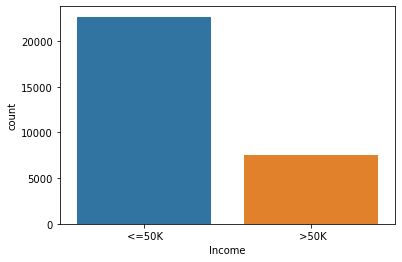

In [15]:
# Univariate Analysis.
sns.countplot('Income', data=df_c)

We can see that there are more population with Income <=50K than that of population more that 50K.

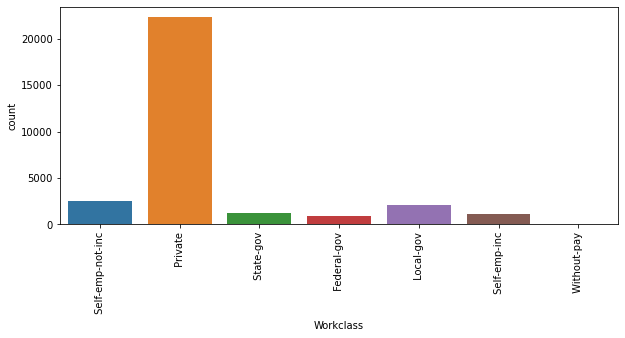

In [16]:
plt.figure(figsize=(10,4))
sns.countplot('Workclass', data=df_c)
plt.xticks(rotation=90)
plt.show()

We can see that more and more population is working in Private sector. 

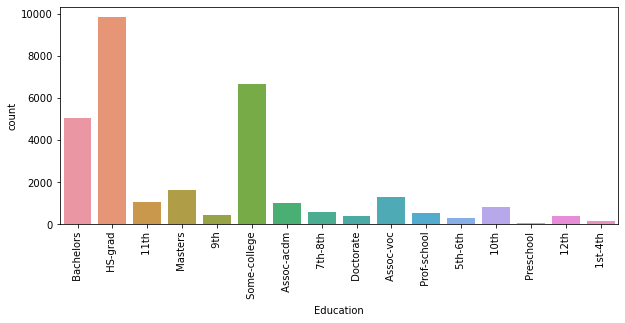

In [18]:
plt.figure(figsize=(10,4))
sns.countplot('Education', data= df_c)
plt.xticks(rotation=90)
plt.show()

We can observe that Maximum population is atleast High School graduate followed by some college. And mini value is Pre school.

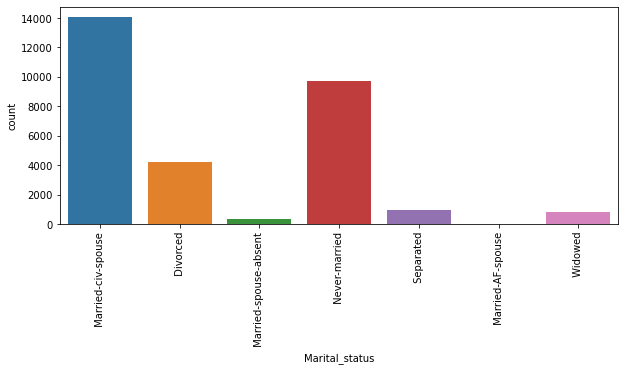

In [19]:
plt.figure(figsize=(10,4))

sns.countplot('Marital_status', data=df_c)
plt.xticks(rotation =90)
plt.show()

We can observe that Married-civ-spouse has highest population followed by Never Married

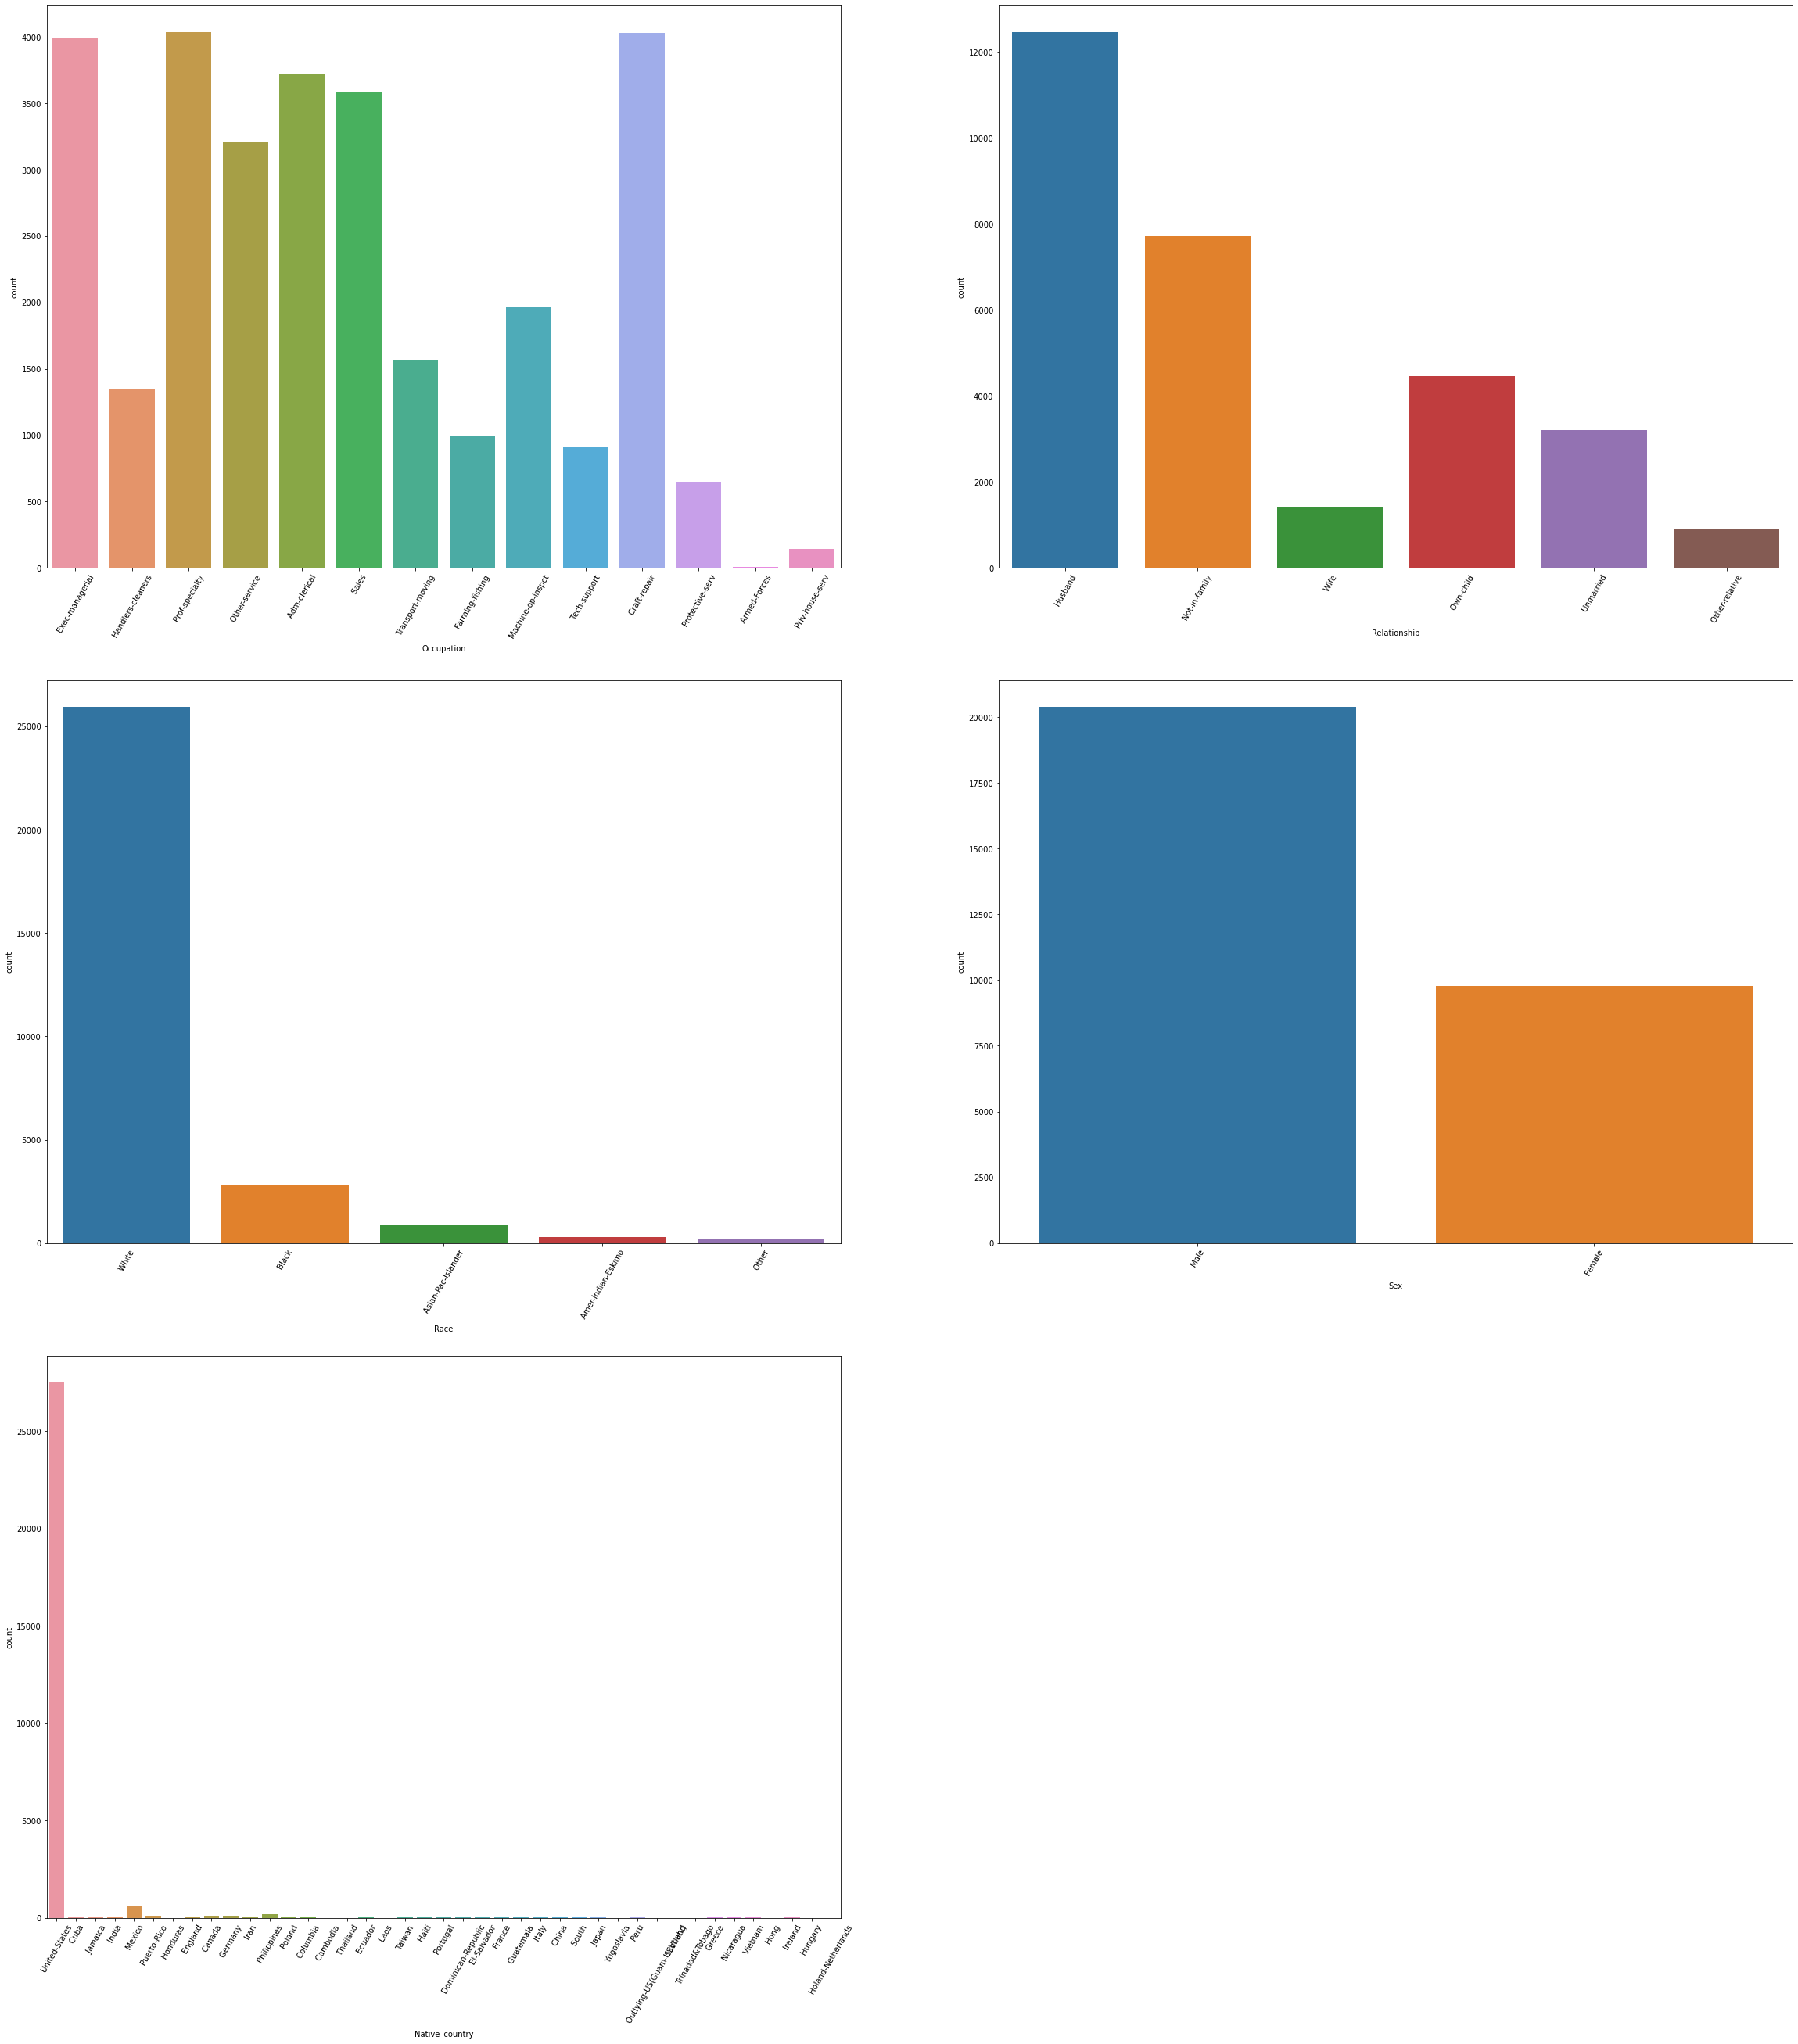

In [20]:
feature=['Occupation', 'Relationship','Race','Sex','Native_country']
plt.figure(figsize=(40,45))
plotnumber=1
for i in df_c[feature]:
    if plotnumber<=5:
        ax=plt.subplot(3,2,plotnumber)
        sns.countplot(df_c[i], data=df_c)
        plt.xticks(rotation=60)
    plotnumber+=1
plt.show()

We can Observe that Prof speciality as occupation has highest, Husband, white, male and united states are the top categories in the remaining columns. Now let's move ahead with continuous data.

In [21]:
df_c.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

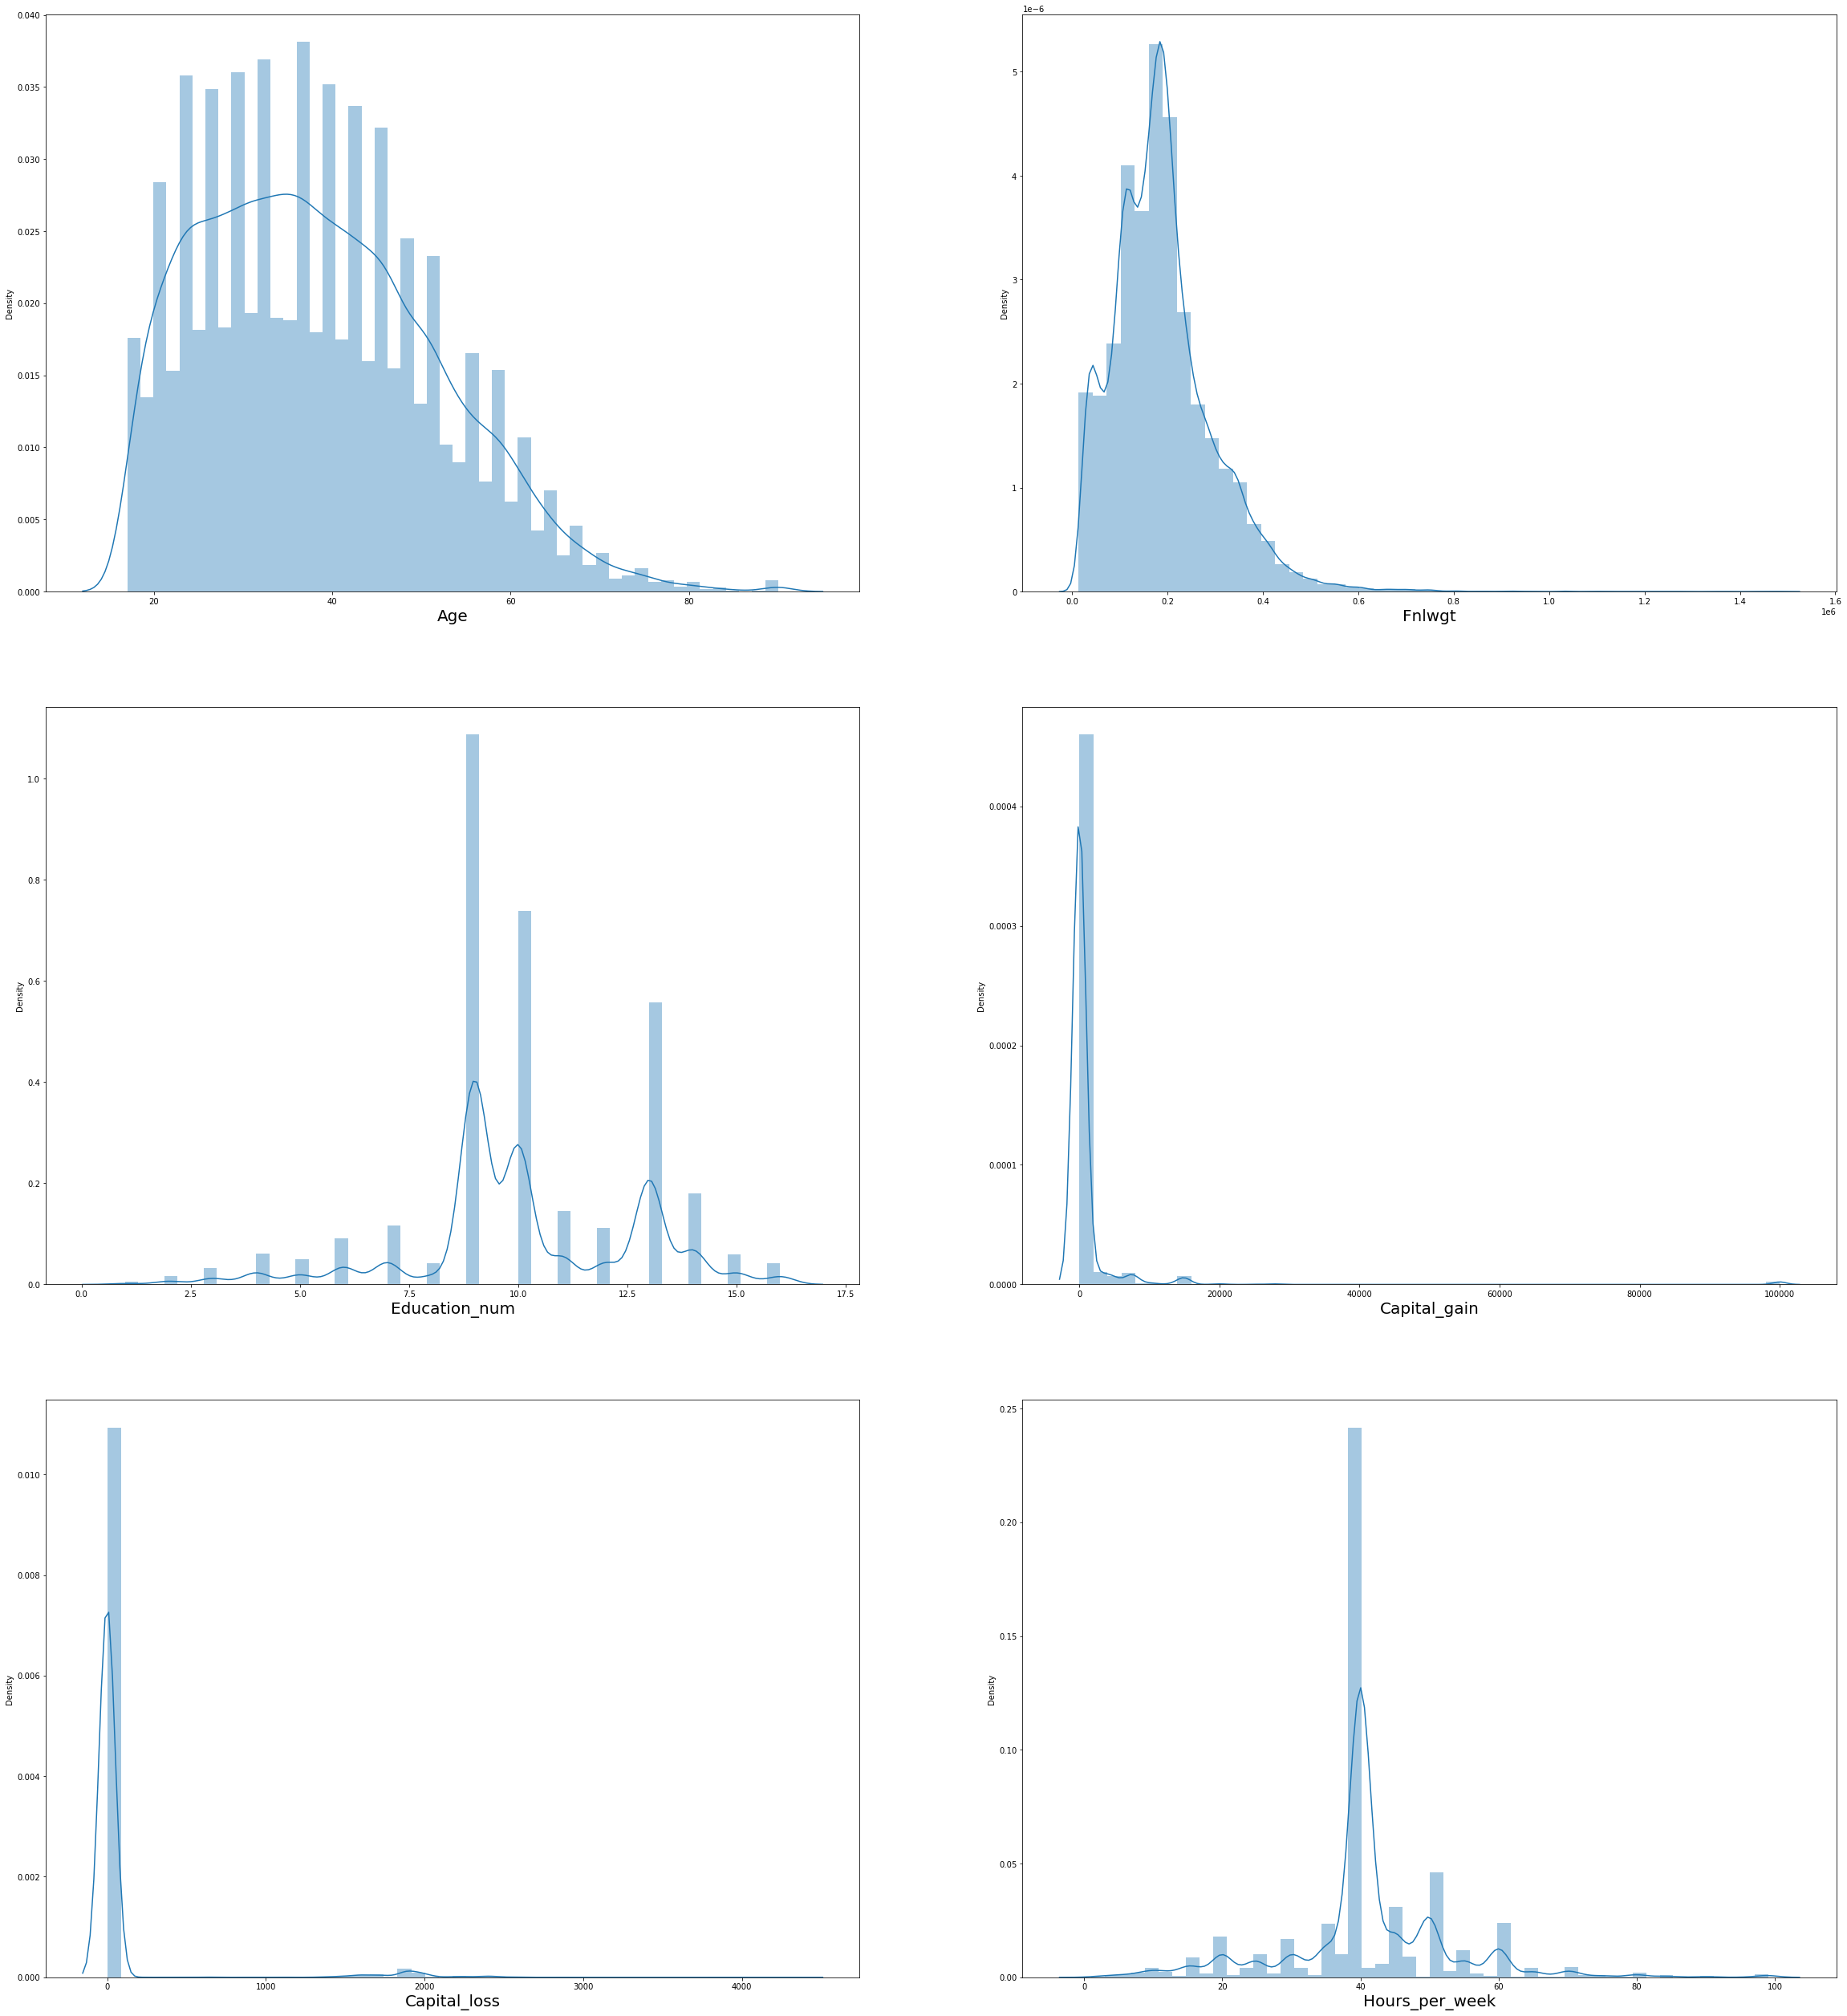

In [22]:
feature_conti=['Age','Fnlwgt','Education_num','Capital_gain','Capital_loss','Hours_per_week']

plt.figure(figsize=(40,45))
plotnumber=1
for i in df_c[feature_conti]:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.distplot(df_c[i])
        plt.xlabel(i,fontsize= 20)
        
    plotnumber+=1
plt.show()


We can observe that data is skewed and not on same scale. We will need to remove the skewness before building the model.

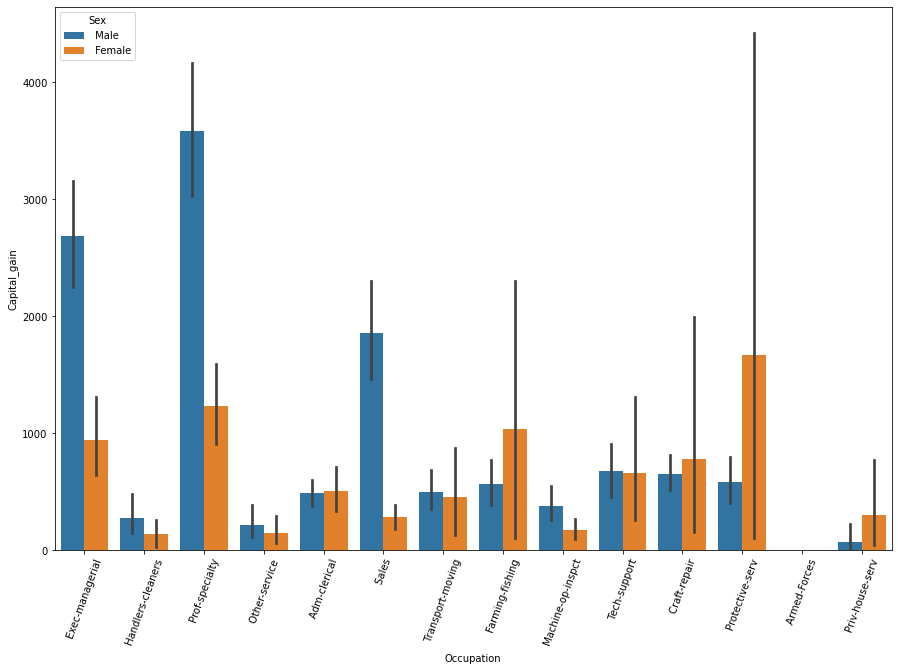

In [23]:
plt.figure(figsize=(15,10))
sns.barplot(x='Occupation',y='Capital_gain',data=df_c,hue='Sex')
plt.xticks(rotation=70)
plt.show()

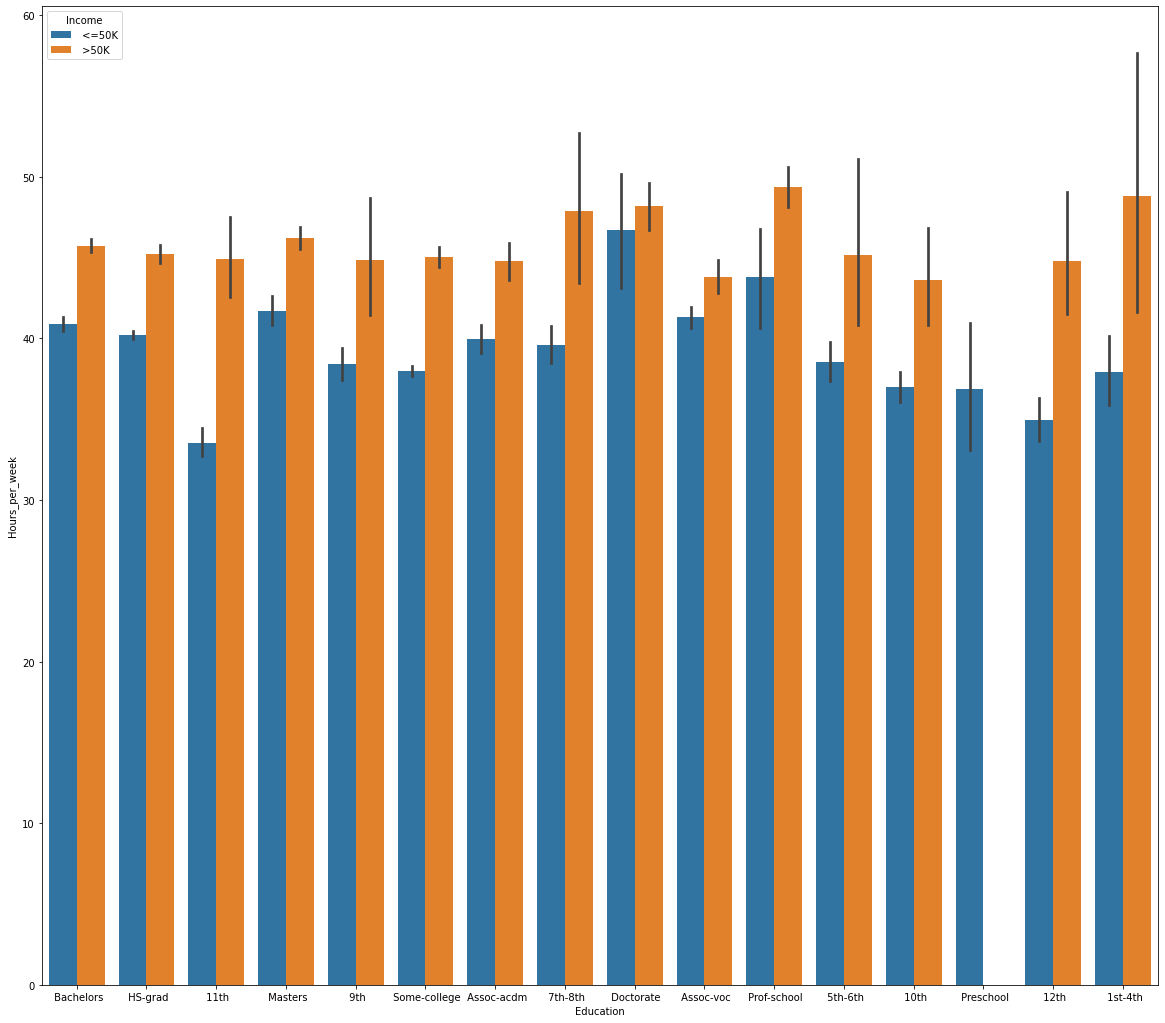

In [24]:
plt.figure(figsize=(20,18))
sns.barplot(x='Education',y='Hours_per_week',data=df_c,hue='Income')
plt.show()
##Checking the distribution of Education and  Hours_per_week as gender###

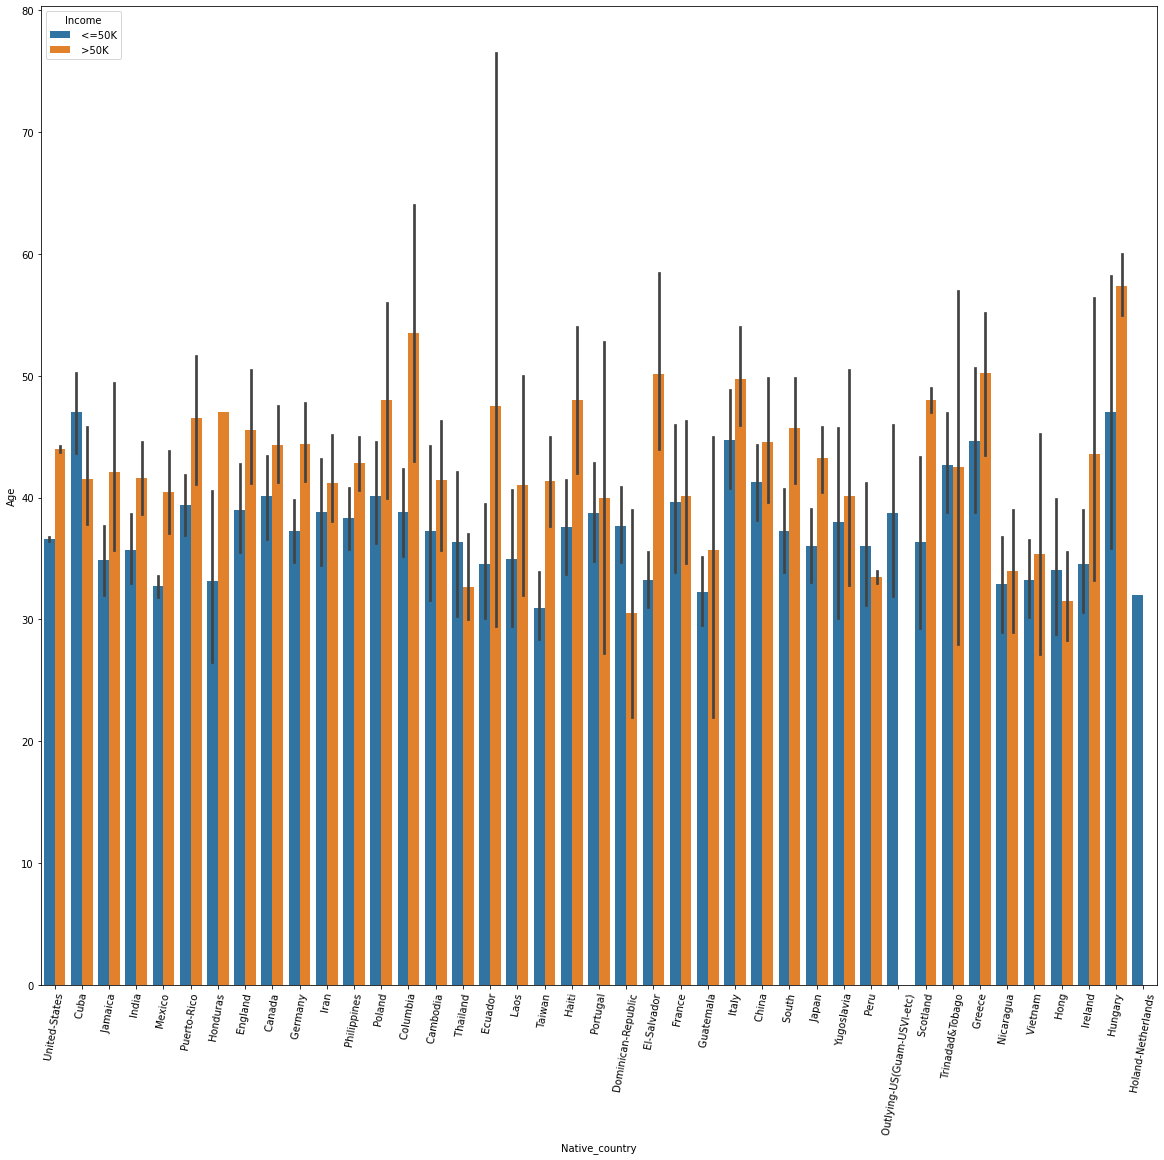

In [25]:
plt.figure(figsize=(20,18))
sns.barplot(x='Native_country',y='Age',data=df_c,hue='Income')
plt.xticks(rotation=80)
plt.show()

We can observe that Otlying-US, the INcome >50K is almost nill

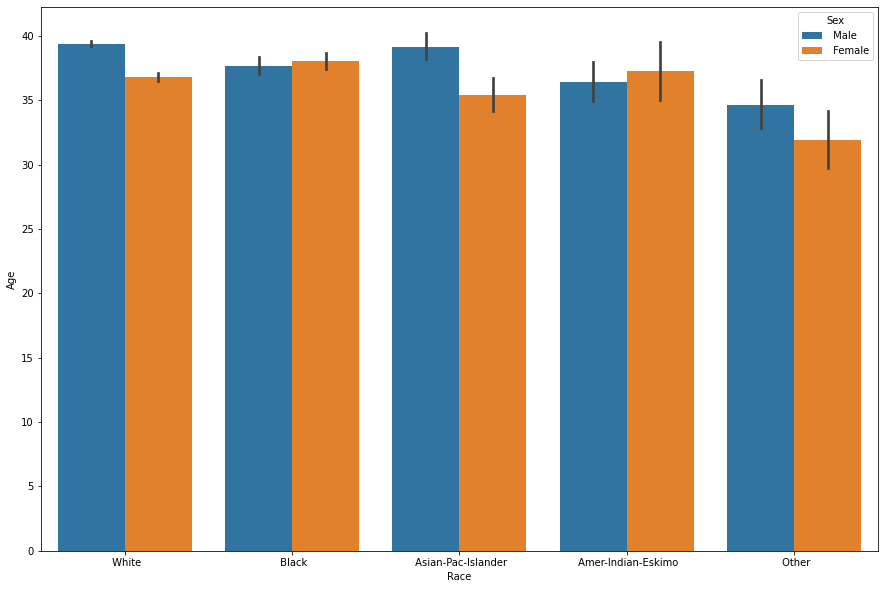

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(x='Race',y='Age',data=df_c,hue='Sex')
plt.show()

It is interesting to observe that among Black and Amer-Indian-Eskimo the number of females are higher that male.

<AxesSubplot:xlabel='Capital_gain', ylabel='Occupation'>

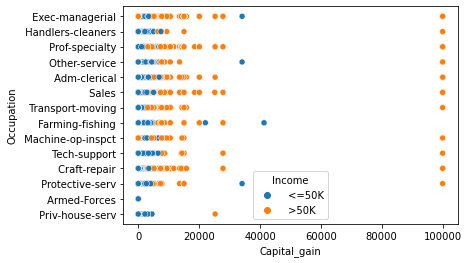

In [27]:
sns.scatterplot(x='Capital_gain', y='Occupation', data=df_c, hue='Income')

We can observe that >50K has some really capital gain overall, while <=50K has around 0-5K Capital gain. In case of Farming-fishing the highest capital gain earned by <=50K.

<AxesSubplot:xlabel='Capital_loss', ylabel='Occupation'>

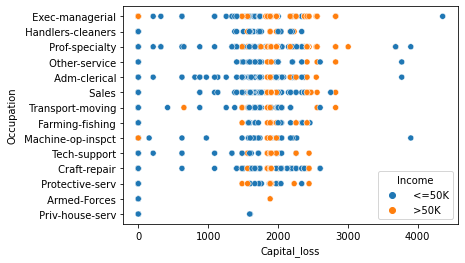

In [28]:
sns.scatterplot(x='Capital_loss', y='Occupation', data=df_c, hue='Income')

We can overall observe that Capital loss occurs to <=50K income group and for >50K Income group, capital loss is in range 1800-2500 range.

In [29]:
# using label Encoder for the categorial features with to integral form
from sklearn.preprocessing import LabelEncoder
lab_enc= LabelEncoder()
df_c['Income']= lab_enc.fit_transform(df_c['Income'])
df_c['Sex']= lab_enc.fit_transform(df_c['Sex'])
df_c['Race']=lab_enc.fit_transform(df_c['Race'])
df_c['Native_country']=lab_enc.fit_transform(df_c['Native_country'])
df_c['Occupation']= lab_enc.fit_transform(df_c['Occupation'])
df_c['Education']= lab_enc.fit_transform(df_c['Education'])
df_c['Marital_status']= lab_enc.fit_transform(df_c['Marital_status'])
df_c['Workclass']=lab_enc.fit_transform(df_c['Workclass'])
df_c['Relationship']=lab_enc.fit_transform(df_c['Relationship'])

In [30]:
# lets make correlation matrix to get an idea about the features and labels correlation with each other.
df_c.corr()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
Age,1.000000,0.080548,-0.076511,-0.001111,0.043525,-0.276378,-0.005680,-0.246456,0.023373,0.081992,0.080154,0.060166,0.101599,-0.001905,0.242000
Workclass,0.080548,1.000000,-0.032395,0.017892,0.037729,-0.034338,0.015719,-0.067401,0.044700,0.074917,0.035340,0.007226,0.050738,0.007644,0.018103
Fnlwgt,-0.076511,-0.032395,1.000000,-0.027115,-0.044954,0.032197,0.000152,0.009289,-0.023882,0.025387,0.000427,-0.009757,-0.022889,-0.066709,-0.008978
Education,-0.001111,0.017892,-0.027115,1.000000,0.345431,-0.040654,-0.038231,-0.012720,0.011158,-0.027880,0.030577,0.015025,0.059887,0.078794,0.078981
Education_num,0.043525,0.037729,-0.044954,0.345431,1.000000,-0.063457,0.087778,-0.091928,0.032791,0.006131,0.124413,0.079656,0.152528,0.091547,0.335317
Marital_status,-0.276378,-0.034338,0.032197,-0.040654,-0.063457,1.000000,0.022702,0.177975,-0.068641,-0.119837,-0.042424,-0.035197,-0.189004,-0.025911,-0.193504
Occupation,-0.005680,0.015719,0.000152,-0.038231,0.087778,0.022702,1.000000,-0.053742,0.000736,0.062350,0.022170,0.014597,0.018362,-0.003470,0.051551
Relationship,-0.246456,-0.067401,0.009289,-0.012720,-0.091928,0.177975,-0.053742,1.000000,-0.117140,-0.584876,-0.058258,-0.063569,-0.257851,-0.010806,-0.251009
Race,0.023373,0.044700,-0.023882,0.011158,0.032791,-0.068641,0.000736,-0.117140,1.000000,0.089178,0.014351,0.023520,0.048533,0.124511,0.071666
Sex,0.081992,0.074917,0.025387,-0.027880,0.006131,-0.119837,0.062350,-0.584876,0.089178,1.000000,0.048811,0.047017,0.231272,0.000612,0.216715


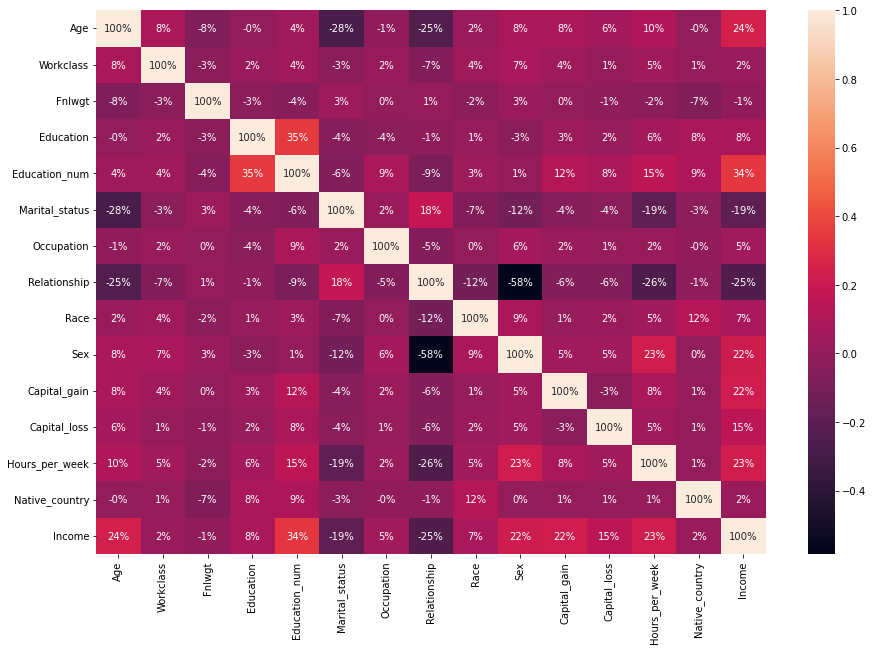

In [31]:
# Let's visualise it using HeatMap.
plt.figure(figsize=(15,10))
sns.heatmap(df_c.corr(), annot= True, fmt='.0%')
plt.show()

From here we can observe that Education_num is highly correlated to income and Fnlwgt is least correlated.

<AxesSubplot:xlabel='Sex', ylabel='Income'>

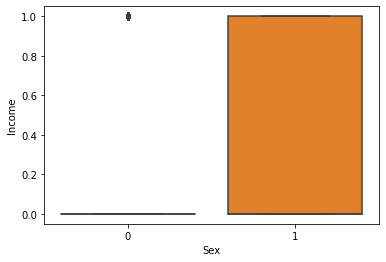

In [37]:
sns.boxplot(x='Sex', y='Income', data=df_c)

It is interesting to observe that mostly Male has income >50K. There is huge disparity in income among male and female.

<AxesSubplot:xlabel='Income', ylabel='count'>

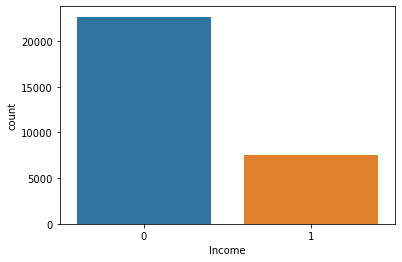

In [38]:
# let's one more time check the count for income
sns.countplot('Income', data=df_c)

We can see sight imbalance among the classes of Income, We might need to treat this imbalance if our Model shows baisness.

# Skewness and Outlier

In [39]:
df_c.skew()

Age                0.530223
Workclass          1.154786
Fnlwgt             1.459212
Education         -0.944971
Education_num     -0.305328
Marital_status    -0.009387
Occupation         0.110420
Relationship       0.820275
Race              -2.506976
Sex               -0.750584
Capital_gain      11.902511
Capital_loss       4.526294
Hours_per_week     0.330856
Native_country    -4.178826
Income             1.161357
dtype: float64

In [41]:
# Let's do Power Transform to remove skewness.
from sklearn.preprocessing import PowerTransformer
pwrTrans=PowerTransformer(method='yeo-johnson')  
feature_conti=['Age','Fnlwgt','Education_num','Capital_gain','Capital_loss','Hours_per_week']
df_c[feature_conti]=pwrTrans.fit_transform(df_c[feature_conti].values)

We only remove skewness from continuous features, not from categorical features or label.

In [42]:
df_c.skew()

Age               0.014020
Workclass         1.154786
Fnlwgt            0.056445
Education        -0.944971
Education_num     0.026696
Marital_status   -0.009387
Occupation        0.110420
Relationship      0.820275
Race             -2.506976
Sex              -0.750584
Capital_gain      2.996862
Capital_loss      4.264671
Hours_per_week    0.035108
Native_country   -4.178826
Income            1.161357
dtype: float64

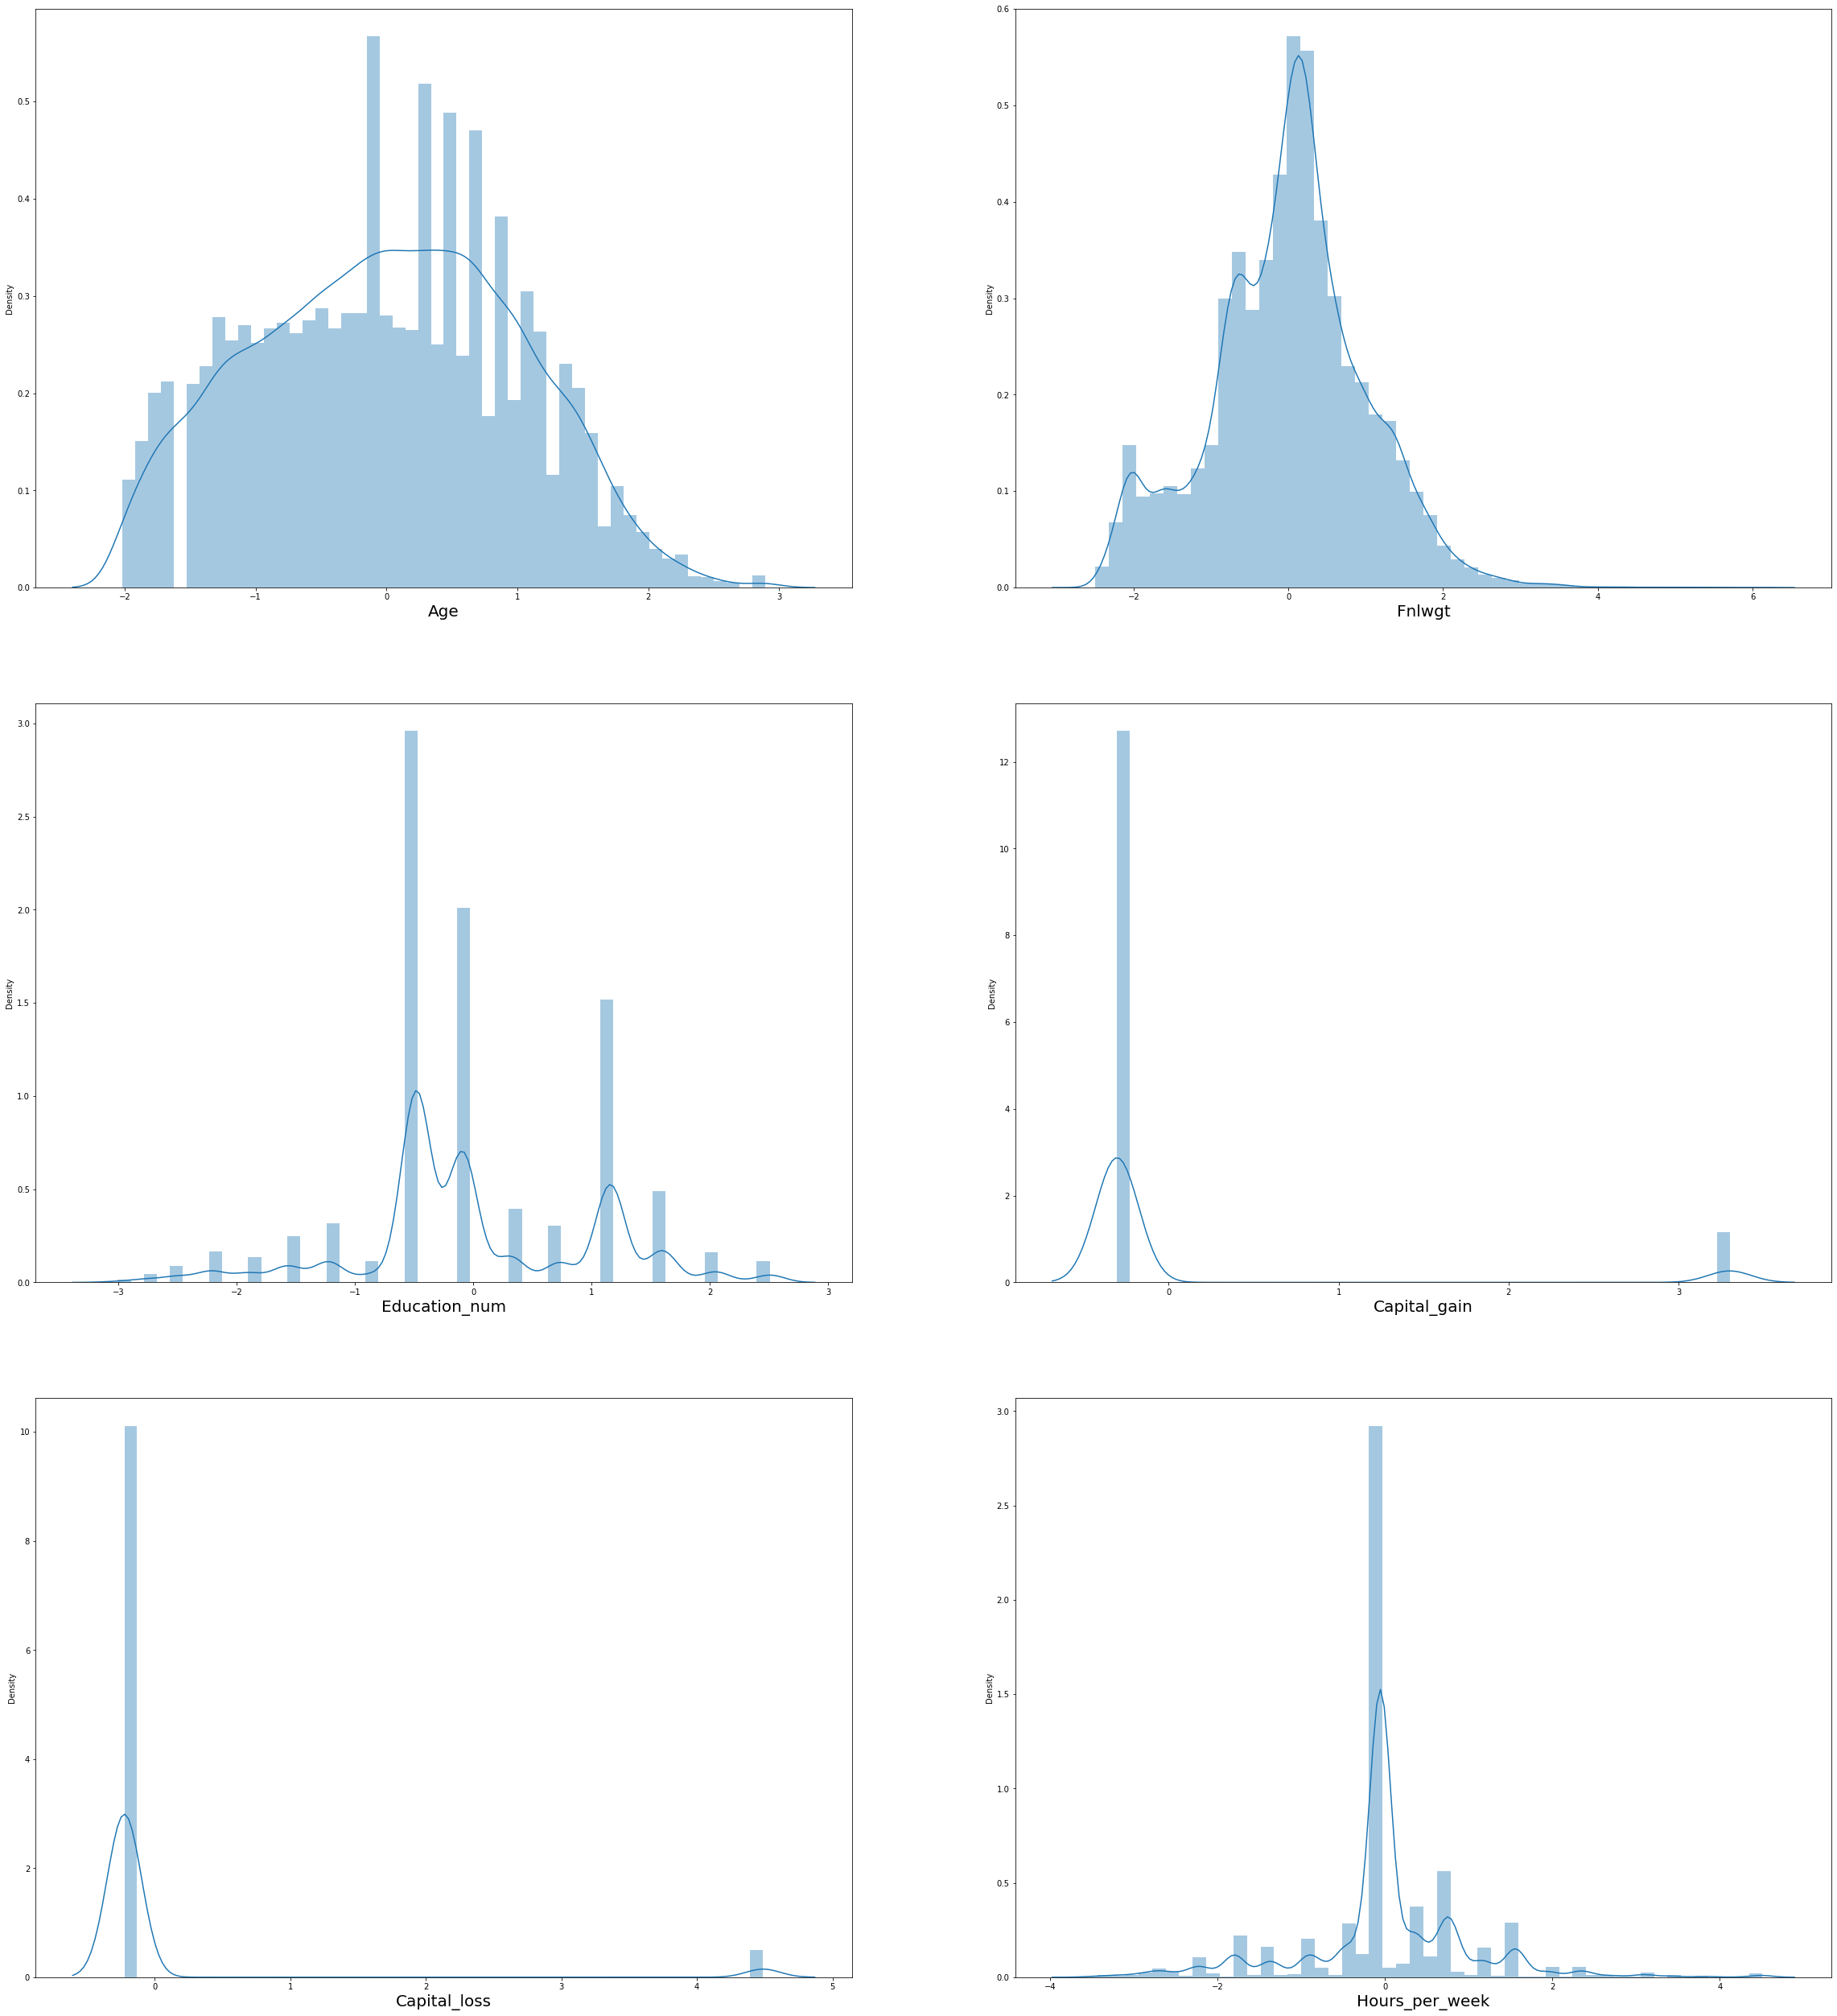

In [43]:
#let's visualise it
feature_conti=['Age','Fnlwgt','Education_num','Capital_gain','Capital_loss','Hours_per_week']

plt.figure(figsize=(40,45))
plotnumber=1
for i in df_c[feature_conti]:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.distplot(df_c[i])
        plt.xlabel(i,fontsize= 20)
        
    plotnumber+=1
plt.show()

Data looks better, Now lets move ahead and remove the outlier.

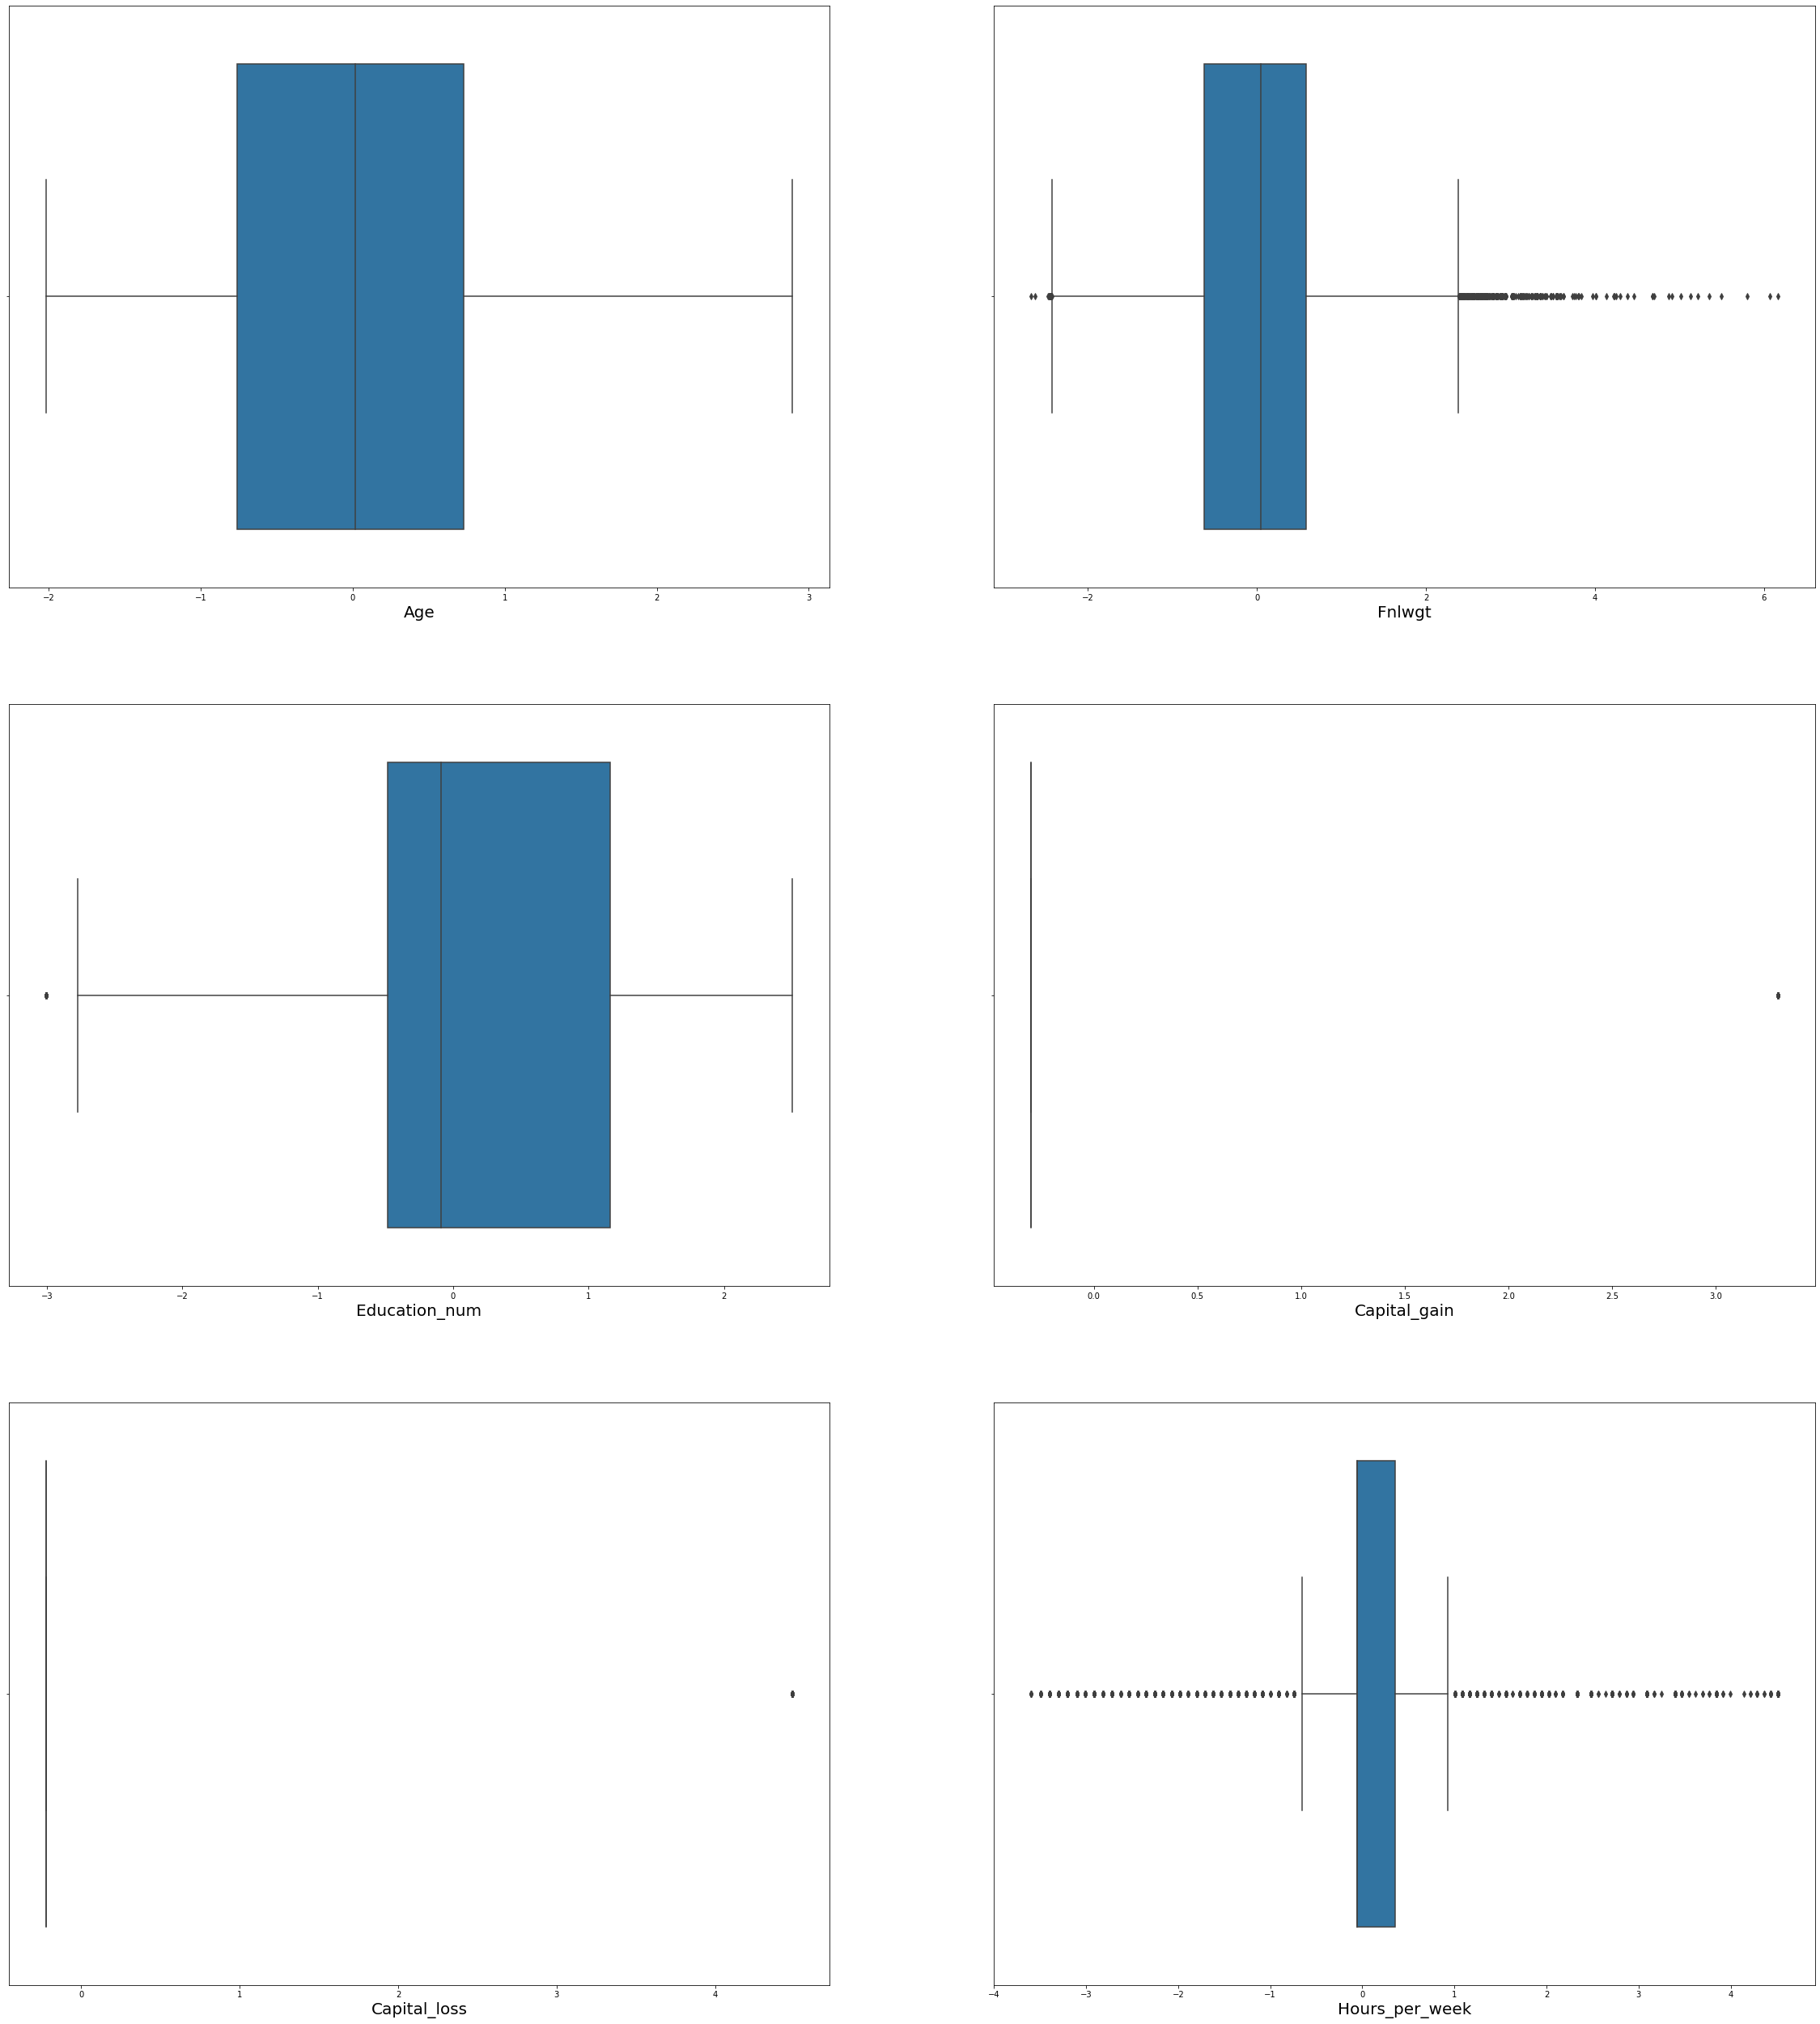

In [44]:
# let's visualize  for outlier

feature_conti=['Age','Fnlwgt','Education_num','Capital_gain','Capital_loss','Hours_per_week']

plt.figure(figsize=(40,45))
plotnumber=1
for i in df_c[feature_conti]:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.boxplot(df_c[i])
        plt.xlabel(i,fontsize= 20)
        
    plotnumber+=1
plt.show()

There are some points , but lets check using z score. In Capital_gain and Capital_loss we can see only two points so let's not touch them, because removing outlier from them , might lead to potential data loss. So well check for outlier on all the continuous features except these two.

In [45]:
# for Outliers Dection and removal we will use Z- Score Method
from scipy import stats
feature=['Age','Fnlwgt','Education_num','Hours_per_week']
df_out=pd.DataFrame(df_c[feature])
z= np.abs(stats.zscore(df_out))
threshold = 3
print(np.where(z>3))

(array([    9,    25,   144,   168,   174,   199,   207,   250,   276,
         359,   383,   439,   476,   541,   629,   759,   769,   806,
         856,   859,   933,   978,   980,  1078,  1102,  1168,  1173,
        1185,  1274,  1300,  1348,  1378,  1434,  1463,  1545,  1588,
        1675,  1734,  1774,  1795,  2004,  2148,  2161,  2179,  2232,
        2247,  2308,  2465,  2647,  2668,  2681,  2704,  2715,  2718,
        2732,  2787,  2839,  2932,  2961,  3028,  3029,  3067,  3165,
        3284,  3391,  3429,  3442,  3586,  3635,  3750,  3766,  3856,
        3882,  3921,  3936,  3948,  3951,  3984,  4068,  4185,  4190,
        4336,  4448,  4554,  4661,  4805,  4919,  4925,  4969,  4978,
        5011,  5031,  5046,  5048,  5090,  5128,  5156,  5210,  5359,
        5391,  5508,  5551,  5573,  5587,  5668,  5679,  5754,  5763,
        5867,  5877,  5917,  5958,  6005,  6078,  6092,  6162,  6209,
        6210,  6253,  6257,  6285,  6307,  6323,  6355,  6518,  6560,
        6582,  6595

In [46]:
# Removing outliers from the data frame, and storing final value in df_out Dataframe.
df_out= df_c[(z<3).all(axis=1)]
df_out.shape                            # checking the shape of dataframe after removing outliers 

(29527, 15)

In [47]:
# once again checking for skewness 
df_out.skew()

Age               0.011280
Workclass         1.164980
Fnlwgt           -0.102790
Education        -0.942399
Education_num     0.052072
Marital_status   -0.012571
Occupation        0.113309
Relationship      0.819328
Race             -2.513719
Sex              -0.747183
Capital_gain      2.998190
Capital_loss      4.264682
Hours_per_week   -0.395317
Native_country   -4.196540
Income            1.160349
dtype: float64

Data looks fine, only skewness present are the ones which we don't treat as they might be categorical features or label or to prevent important information to loose.

Let's move ahead and scale out data so that it will be on the same scale. But before that , we will chcek out dataset one more time.

In [49]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29527 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             29527 non-null  float64
 1   Workclass       29527 non-null  int32  
 2   Fnlwgt          29527 non-null  float64
 3   Education       29527 non-null  int32  
 4   Education_num   29527 non-null  float64
 5   Marital_status  29527 non-null  int32  
 6   Occupation      29527 non-null  int32  
 7   Relationship    29527 non-null  int32  
 8   Race            29527 non-null  int32  
 9   Sex             29527 non-null  int32  
 10  Capital_gain    29527 non-null  float64
 11  Capital_loss    29527 non-null  float64
 12  Hours_per_week  29527 non-null  float64
 13  Native_country  29527 non-null  int32  
 14  Income          29527 non-null  int32  
dtypes: float64(6), int32(9)
memory usage: 2.6 MB


The dataset looks good, every column is in numerical form, there is no null values. It is safe to proceed further with data scaling and then Mofdel Building 

# Scaling

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [51]:
# separating features and label
X=df_out.drop('Income', axis=1)
y=df_out.Income

In [52]:
# scaling the features using StandardScaler

scalar= StandardScaler()
X_scaled=scalar.fit_transform(X)

In [53]:
X_scaled.shape

(29527, 14)

In [54]:
y.shape

(29527,)

In [55]:
# VIF checking for multicollinearity
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

Finding variance inflation factor in each scaled column i.e X_scaled.shape[1] (1/1-R2): here R2=actual-predicted
,this method help us to identify multicollinearity.


In [57]:
vif=pd.DataFrame()
vif["vif"]= [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"]=X.columns

#let's check the values
vif

,vif,Features
0,1.212834,Age
1,1.013980,Workclass
2,1.012593,Fnlwgt
3,1.127314,Education
4,1.191575,Education_num
5,1.155228,Marital_status
6,1.020242,Occupation
7,1.679433,Relationship
8,1.035457,Race
9,1.569687,Sex


All the values are before 5 so we can say that there is no multicollinearity present in our data. WE can say that the data is safe to proceed ahead in Model building.

# Model Building

In [58]:
# splitting data into train test form
X_train,X_test, y_train,y_test=train_test_split(X_scaled,y,test_size=0.25)

# Logistic Regression

In [103]:
# importing the library
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score,precision_score

# model
LR= LogisticRegression()


maxAccu=0   # maximum accuracy
maxRS=0    #best random state value for which max accuracy is achieved

# Determing Best random_state, for maximum accuracy/

for i in range(1,200):
    X_train,X_test,y_train,y_test= train_test_split(X_scaled,y,test_size=0.25, random_state=i)
    LR.fit(X_train,y_train)   #fitting the data will train your model
    Y_pred=LR.predict(X_test)    # this is predicted target variable
    acc= accuracy_score(y_test,Y_pred)   # accuracy score
    print('Accuracy ', acc, 'Random state ', i)
    
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
        print("Max accuracy ", maxAccu, " at random state ", i)
    

print("Best accuracy is ", maxAccu, "at random state ", maxRS)


Accuracy  0.8104849634245462 Random state  1
Max accuracy  0.8104849634245462  at random state  1
Accuracy  0.8148198320238418 Random state  2
Max accuracy  0.8148198320238418  at random state  2
Accuracy  0.8198320238417773 Random state  3
Max accuracy  0.8198320238417773  at random state  3
Accuracy  0.8176645895421295 Random state  4
Accuracy  0.8169872663234896 Random state  5
Accuracy  0.812516933080466 Random state  6
Accuracy  0.8145489027363858 Random state  7
Accuracy  0.8167163370360336 Random state  8
Accuracy  0.8108913573557301 Random state  9
Accuracy  0.8107558927120022 Random state  10
Accuracy  0.8205093470604172 Random state  11
Max accuracy  0.8205093470604172  at random state  11
Accuracy  0.8161744784611217 Random state  12
Accuracy  0.8173936602546735 Random state  13
Accuracy  0.813329720942834 Random state  14
Accuracy  0.812787862367922 Random state  15
Accuracy  0.8144134380926579 Random state  16
Accuracy  0.8141425088052019 Random state  17
Accuracy  0.81698

Accuracy  0.8169872663234896 Random state  175
Accuracy  0.8206448117041453 Random state  176
Accuracy  0.8129233270116499 Random state  177
Accuracy  0.8107558927120022 Random state  178
Accuracy  0.8169872663234896 Random state  179
Accuracy  0.8146843673801137 Random state  180
Accuracy  0.812652397724194 Random state  181
Accuracy  0.8156326198862097 Random state  182
Accuracy  0.8215930642102411 Random state  183
Accuracy  0.8100785694933622 Random state  184
Accuracy  0.8146843673801137 Random state  185
Accuracy  0.8114332159306421 Random state  186
Accuracy  0.8096721755621783 Random state  187
Accuracy  0.8114332159306421 Random state  188
Accuracy  0.8165808723923056 Random state  189
Accuracy  0.8179355188295855 Random state  190
Accuracy  0.8087239230560823 Random state  191
Accuracy  0.8159035491736657 Random state  192
Accuracy  0.8176645895421295 Random state  193
Accuracy  0.8183419127607694 Random state  194
Accuracy  0.812652397724194 Random state  195
Accuracy  0.808

The best accuracy is .82457 at random state 54.

In [104]:
# creating train test split for best random state
X_train,X_test,y_train,y_test= train_test_split(X_scaled,y,test_size=0.25, random_state=54)

pred=LR.predict(X_train)
LR_clf_report= pd.DataFrame(classification_report(y_train, pred, output_dict=True))

print("=====================Train Result========================")

print(f"Accuracy Score : {accuracy_score(y_train, pred)*100:.2f}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {LR_clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_train, pred)}\n")


# Test score

y_pred=LR.predict(X_test)
clf_report= pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

print("=====================Test Result========================")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)*100}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_test, y_pred)}\n")
LR_acc= accuracy_score(y_test,y_pred)

=====================Train Result========================
Accuracy Score : 81.00%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                       0            1  accuracy     macro avg  weighted avg
precision      0.835221     0.683740   0.80998      0.759480      0.797161
recall         0.929618     0.453451   0.80998      0.691534      0.809980
f1-score       0.879895     0.545278   0.80998      0.712586      0.795821
support    16581.000000  5564.000000   0.80998  22145.000000  22145.000000


-----------------------------------------------------------
Confusion Matrix : 
 [[15414  1167]
 [ 3041  2523]]

=====================Test Result========================
Accuracy Score : 82.49796803034408%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                      0            1  accuracy    macro avg  weighted avg
precision     0.848775     0.704676   0.82498     0.776725      0.813814
recall 

In [105]:
# Cross Validation

from sklearn.model_selection import cross_val_score

# validating accuracy

scr= cross_val_score(LR, X_scaled, y,scoring='precision' ,cv=10)
LR_scr=scr.mean()
print("Cross Validation Score For Logistic Regression model : ", LR_scr)

Cross Validation Score For Logistic Regression model :  0.6899494002074484


We can observe that , the train and test and cross validation score are almost in line. Logistic Regression fits our dataset so far.

# KNN Classifier

In [107]:
#import library
from sklearn.neighbors import KNeighborsClassifier

#model
KNN= KNeighborsClassifier()

#fit
KNN.fit(X_train,y_train)

#predict
pred=KNN.predict(X_train)
KNN_clf_report= pd.DataFrame(classification_report(y_train, pred, output_dict=True))

print("=====================Train Result========================")

print(f"Accuracy Score : {accuracy_score(y_train, pred)*100:.2f}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {KNN_clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_train, pred)}\n")


# Test score

y_pred=KNN.predict(X_test)
clf_report= pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

print("=====================Test Result========================")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)*100}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_test, y_pred)}\n")
KNN_acc= accuracy_score(y_test,y_pred)


=====================Train Result========================
Accuracy Score : 87.06%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                       0            1  accuracy     macro avg  weighted avg
precision      0.905511     0.757883  0.870625      0.831697      0.868419
recall         0.923587     0.712797  0.870625      0.818192      0.870625
f1-score       0.914460     0.734649  0.870625      0.824554      0.869282
support    16581.000000  5564.000000  0.870625  22145.000000  22145.000000


-----------------------------------------------------------
Confusion Matrix : 
 [[15314  1267]
 [ 1598  3966]]

=====================Test Result========================
Accuracy Score : 82.49796803034408%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                      0            1  accuracy    macro avg  weighted avg
precision     0.879703     0.644974   0.82498     0.762339      0.822754
recall 

In [108]:
# Cross validation
scr= cross_val_score(KNN, X_scaled, y,scoring='precision', cv=10)
KNN_scr=scr.mean()
print("Cross Validation Score For KNeighborsClassifier model : ", KNN_scr)

Cross Validation Score For KNeighborsClassifier model :  0.6449180179170445


# Ensemble Model

In [109]:
from sklearn.ensemble import RandomForestClassifier

RF= RandomForestClassifier()

RF.fit(X_train,y_train)
pred=RF.predict(X_train)
RF_clf_report= pd.DataFrame(classification_report(y_train, pred, output_dict=True))

print("=====================Train Result========================")

print(f"Accuracy Score : {accuracy_score(y_train, pred)*100:.2f}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {RF_clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_train, pred)}\n")


# Test score

y_pred=RF.predict(X_test)
clf_report= pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

print("=====================Test Result========================")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)*100}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_test, y_pred)}\n")
RF_acc=accuracy_score(y_test,y_pred)

=====================Train Result========================
Accuracy Score : 99.99%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                       0            1  accuracy    macro avg  weighted avg
precision      0.999819     1.000000  0.999865      0.99991      0.999865
recall         1.000000     0.999461  0.999865      0.99973      0.999865
f1-score       0.999910     0.999730  0.999865      0.99982      0.999865
support    16581.000000  5564.000000  0.999865  22145.00000  22145.000000


-----------------------------------------------------------
Confusion Matrix : 
 [[16581     0]
 [    3  5561]]

=====================Test Result========================
Accuracy Score : 84.04226496884313%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                      0            1  accuracy    macro avg  weighted avg
precision     0.881549     0.691682  0.840423     0.786616      0.835484
recall      

In [110]:
# Cross validation
scr= cross_val_score(RF,X_scaled,y,scoring='precision', cv=10)
RF_scr=scr.mean()
print("Cross validation Score of RandomForestClassifier model is : ", RF_scr)

Cross validation Score of RandomForestClassifier model is :  0.6878120370861478


In [119]:
# Hyper Parameter Tunning Randome forest Classifier
RandomForestClassifier()
#creating parameter list to pass in GridSearchCV
parameters={'max_features': ['auto','sqrt','log2'],
           'n_estimators': [10,50,70,100],
            'max_depth': range(5,10,15),
            'criterion': ['gini','entropy']}

GCV=GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring= "accuracy")
GCV.fit(X_train,y_train)    #fitting data into model
GCV.best_params_  # printing best parameter found by GridSearchCV

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 50}

In [120]:
GCV_pred=GCV.best_estimator_.predict(X_test)   #predicting using best parameters
accuracy_score(y_test, GCV_pred)   # checking the accuracy

0.8302628014088322

In [121]:
precision_score(y_test,GCV_pred)

0.75187265917603

# Boosting

In [111]:
# Model
from sklearn.ensemble import GradientBoostingClassifier

GBC= GradientBoostingClassifier()

#fit
GBC.fit(X_train, y_train)

pred=GBC.predict(X_train)
GBC_clf_report= pd.DataFrame(classification_report(y_train, pred, output_dict=True))

print("=====================Train Result========================")

print(f"Accuracy Score : {accuracy_score(y_train, pred)*100:.2f}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {GBC_clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_train, pred)}\n")


# Test score

y_pred=GBC.predict(X_test)
clf_report= pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

print("=====================Test Result========================")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)*100}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_test, y_pred)}\n")
GBC_acc=accuracy_score(y_test,y_pred)


=====================Train Result========================
Accuracy Score : 84.77%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                       0            1  accuracy     macro avg  weighted avg
precision      0.873917     0.744534  0.847731      0.809225      0.841409
recall         0.930945     0.599748  0.847731      0.765347      0.847731
f1-score       0.901530     0.664344  0.847731      0.782937      0.841936
support    16581.000000  5564.000000  0.847731  22145.000000  22145.000000


-----------------------------------------------------------
Confusion Matrix : 
 [[15436  1145]
 [ 2227  3337]]

=====================Test Result========================
Accuracy Score : 85.3427255486318%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                      0            1  accuracy    macro avg  weighted avg
precision     0.879993     0.744651  0.853427     0.812322      0.847157
recall  

In [112]:
# Cross validation
scr= cross_val_score(GBC,X_scaled,y,scoring='precision', cv=10)
GBC_scr=scr.mean()
print("Cross validation Score of GradientBoosting Classifier model is : ", GBC_scr)

Cross validation Score of GradientBoosting Classifier model is :  0.7358049089787835


In [125]:
# Hyper parameter tuning for GradientBoosting Classifier by using RandomisedSearchCV

# creating list of parameters

grid_param={ 'max_depth': range(3,13),
           'min_samples_split': range(2,8,2),
           'learning_rate': np.arange(0.1, 0.5,1.0),
           'loss' : ['log_loss', 'deviance', 'exponential']}

rnd_srch = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions= grid_param)
#fit
rnd_srch.fit(X_train,y_train)
rnd_srch.best_params_    # finding best parameters



{'min_samples_split': 6,
 'max_depth': 4,
 'loss': 'log_loss',
 'learning_rate': 0.1}

In [126]:
rnd_pred=rnd_srch.best_estimator_.predict(X_test)
print(f" Precision is : {precision_score(y_test,rnd_pred)}")
print(f" Accuracy score is : {accuracy_score(y_test,rnd_pred)}")
      

 Precision is : 0.7276843467011643
 Accuracy score is : 0.8527499322676781


We are using RandomizedSearchCV here as our dataset is quite big, although gridsearchCv gives best parameter, but its most time consuming method with these parameter and dataset.

# SVC

In [113]:
from sklearn.svm import SVC

svc=SVC()
svc.fit(X_train,y_train)
pred=svc.predict(X_train)
svc_clf_report= pd.DataFrame(classification_report(y_train, pred, output_dict=True))

print("=====================Train Result========================")

print(f"Accuracy Score : {accuracy_score(y_train, pred)*100:.2f}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {svc_clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_train, pred)}\n")


# Test score

y_pred=svc.predict(X_test)
clf_report= pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

print("=====================Test Result========================")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)*100}%")
print("\n")
print("---------------------------------------------------------------")
print(f"CLASSIFICATION REPORT :\n {clf_report}")
print("\n")
print("-----------------------------------------------------------")
print(f"Confusion Matrix : \n {confusion_matrix(y_test, y_pred)}\n")
svc_acc=accuracy_score(y_test,y_pred)


=====================Train Result========================
Accuracy Score : 84.21%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                       0            1  accuracy     macro avg  weighted avg
precision      0.864952     0.745140  0.842131      0.805046      0.834849
recall         0.935167     0.564881  0.842131      0.750024      0.842131
f1-score       0.898690     0.642609  0.842131      0.770650      0.834349
support    16581.000000  5564.000000  0.842131  22145.000000  22145.000000


-----------------------------------------------------------
Confusion Matrix : 
 [[15506  1075]
 [ 2421  3143]]

=====================Test Result========================
Accuracy Score : 83.94743971823354%


---------------------------------------------------------------
CLASSIFICATION REPORT :
                      0            1  accuracy    macro avg  weighted avg
precision     0.865704     0.723122  0.839474     0.794413      0.831111
recall 

In [114]:
# Cross validation

scr= cross_val_score(svc,X_scaled,y,scoring= 'precision', cv=10)
svc_scr=scr.mean()
print("Cross validation Score of SVC model is : ", scr.mean())

Cross validation Score of SVC model is :  0.722261107083359


In [100]:
# Hyper parameter tuning
SVC()
from sklearn.model_selection import GridSearchCV

# selecting for parameters
param_grid= { 'C': [1,3,5,10],
            'gamma' : [.001,.01,.002,.02,.1]}

GCV=GridSearchCV(SVC(), param_grid, cv=5, scoring= "accuracy")
GCV.fit(X_train,y_train)    #fitting data into model
GCV.best_params_  # printing best parameter found by GridSearchCV


{'C': 3, 'gamma': 0.1}

In [101]:
GCV_pred=GCV.best_estimator_.predict(X_test)   #predicting using best parameters
accuracy_score(y_test, GCV_pred)   # checking the accuracy

0.8309401246274722

In [102]:
precision_score(y_test,GCV_pred)   # chceking precision score

0.7067209775967414

In [117]:
# summarizing the Models on the basis of accuracy  and cross validation using presion as scoring.
# we are taking precision as the cross validation parameter as we want to know how correctly our model is able to detect the class

Accuracy=[LR_acc, KNN_acc, RF_acc, GBC_acc, svc_acc]
Cross_valid=[LR_scr,KNN_scr, RF_scr, GBC_scr, svc_scr]


Model= pd.DataFrame({
    'Models':['Logistic Regression','KNeighbors Classifier', 'Random Forest Classifier','GradientBoostingClassifier', 'SVC'], 
    'Accuracy Score': Accuracy, 
    'Cross Validation Score(Precision)': Cross_valid})

Model.sort_values(by ='Cross Validation Score(Precision)', ascending = False )

,Models,Accuracy Score,Cross Validation Score(Precision)
3,GradientBoostingClassifier,0.853427,0.735805
4,SVC,0.839474,0.722261
0,Logistic Regression,0.824980,0.689949
2,Random Forest Classifier,0.840423,0.687812
1,KNeighbors Classifier,0.824980,0.644918


GradientBoostingClassifier seems to be the best model with accuracy score of 85.34% and precision of 73.58% and after hyper parameter tuning that score increase to 75%

# Saving the Model

In [118]:
# Pickeling of file or serialization of a file.

import joblib
joblib.dump(GBC, "Census_Income_project.pkl")

['Census_Income_project.pkl']